# Blueprint and overall stats

In [250]:
# TODO What about the other potency types? core_potency, computer???

In [251]:
# Imports and data preparation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from cardio.blueprints.blueprint_catalog import thecatalog
from cardio import skills, Card

cards = thecatalog._blueprints.instantiate()
attribute_names = [
    "name",
    "potency",
    "core_potency",
    "health",
    "power",
    "has_fire",
    "has_spirits",
    "costs_fire",
    "costs_spirits",
]
skill_types = skills.get_skilltypes(implemented_only=True)
skill_names = [s.__name__ for s in skill_types]

df = pd.DataFrame()
for attr in attribute_names:
    df[attr] = [getattr(c, attr) for c in cards]
df["skills"] = [c.skills.count() for c in cards]
for st, sn in zip(skill_types, skill_names):
    df[sn] = [st in c.skills for c in cards]

df.head(2)


,name,potency,core_potency,health,power,has_fire,has_spirits,costs_fire,costs_spirits,skills,InstantDeath,Fertility,Soaring,Spines,Airdefense,Shield,Underdog,Packrat,LuckyStrike
0,Hamster,14,2,1,0,1,1,0,0,0,False,False,False,False,False,False,False,False,False
1,Koala,9,8,3,1,1,1,1,0,0,False,False,False,False,False,False,False,False,False


## General stats

### Total number of blueprints

In [252]:
len(df)


1483

### Skills by potency

In [253]:
sorted_skills = sorted(
    skills.get_skilltypes(implemented_only=True),
    key=lambda s: s.potency,
    reverse=True,
)
for s in sorted_skills:
    print(f"{s.potency:3} {s.name} {s.symbol}")


  9 Fertility 🐭
  7 Instant Death 💀
  7 Shield 🔰
  6 Packrat 🧺
  4 Underdog 🐩
  3 Spines 🦔
  2 Soaring 🪁
  1 Air Defense 🚀
  0 Lucky Strike 🍀


### Potency ranges

In [254]:
skills_by_potency = sorted(
    skills.get_skilltypes(implemented_only=True),
    key=lambda s: s.potency,
    reverse=True,
)
MINCARD = Card(
    name="Min",
    power=0,
    health=1,
    costs_fire=Card.MAX_ATTR,
    skills=[s for s in skills_by_potency[-Card.MAX_SKILLS :] if s.potency < 0],
    costs_spirits=0,  # 0, bc we can't have both types of costs in a card
    has_spirits=0,
    has_fire=0,
)
MAXCARD = Card(
    name="Max",
    power=Card.MAX_ATTR,
    health=Card.MAX_ATTR,
    costs_fire=0,
    skills=skills_by_potency[: Card.MAX_SKILLS],  # type: ignore
    costs_spirits=0,
    has_spirits=Card.MAX_ATTR,
    has_fire=Card.MAX_ATTR,
)
print()
print("Ranges:")
print(f"Total potency range: [{MINCARD.potency}, {MAXCARD.potency}]")
print(f"Core potency range:  [{MINCARD.core_potency}, {MAXCARD.core_potency}]")

print("\nMin card:")
print(MINCARD)
print("\nMax card:")
print(MAXCARD)



Ranges:
Total potency range: [-8, 106]
Core potency range:  [2, 76]

Min card:
Min  0p 1h
costs: 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 has: - pot: -8/2

Max card:
Max 🐭💀🔰🧺🐩🦔 10p 10h
costs: - has: 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥👻👻👻👻👻👻👻👻👻👻 pot: 106/76


### Health/power histo

Note that health of 0 is not allowed.

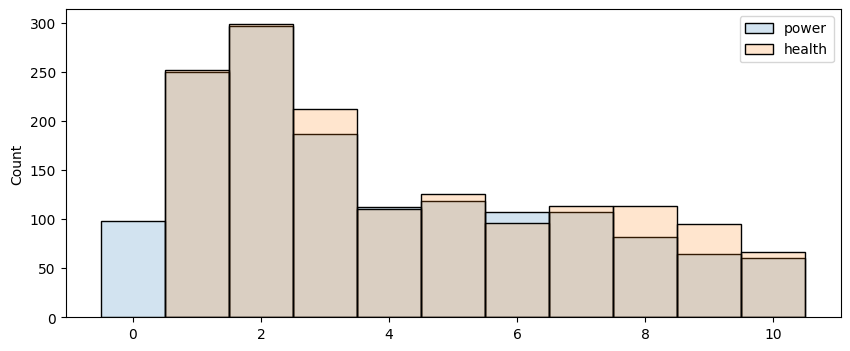

In [267]:
sns.histplot(data=df, x="power", discrete=True, alpha=0.2, label="power")
sns.histplot(data=df, x="health", discrete=True, alpha=0.2, label="health")
plt.gca().set_xlabel("")
plt.legend()
plt.show()


### has_* histo

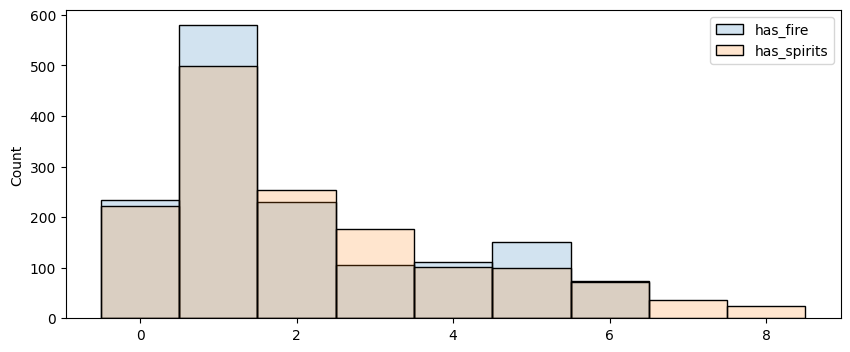

In [256]:
sns.histplot(data=df, x="has_fire", discrete=True, alpha=0.2, label="has_fire")
sns.histplot(data=df, x="has_spirits", discrete=True, alpha=0.2, label="has_spirits")
plt.gca().set_xlabel("")
plt.legend()
plt.show()


### costs_* histo

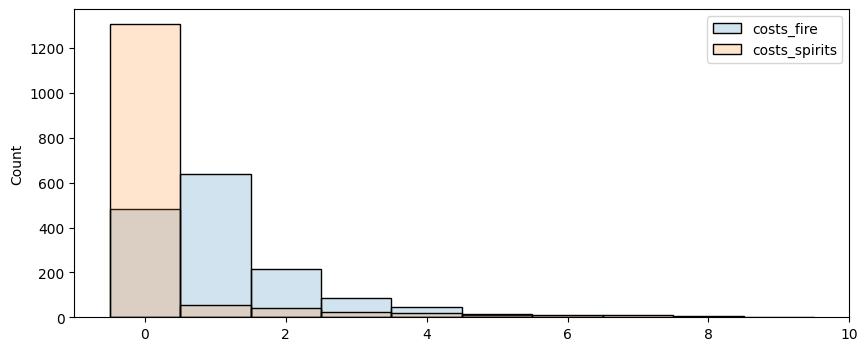

In [257]:
sns.histplot(data=df, x="costs_fire", discrete=True, alpha=0.2, label="costs_fire")
sns.histplot(
    data=df, x="costs_spirits", discrete=True, alpha=0.2, label="costs_spirits"
)
plt.gca().set_xlabel("")
plt.legend()
plt.show()

# TODO This ok? Bug in the code? Need to tweak distribution?


## Potency histo

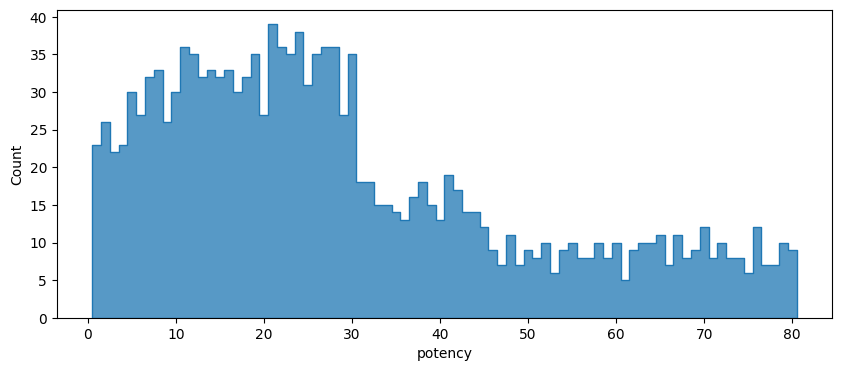

In [258]:
_ = sns.histplot(data=df, x="potency", discrete=True, element="step")


## Potency and core potency histo

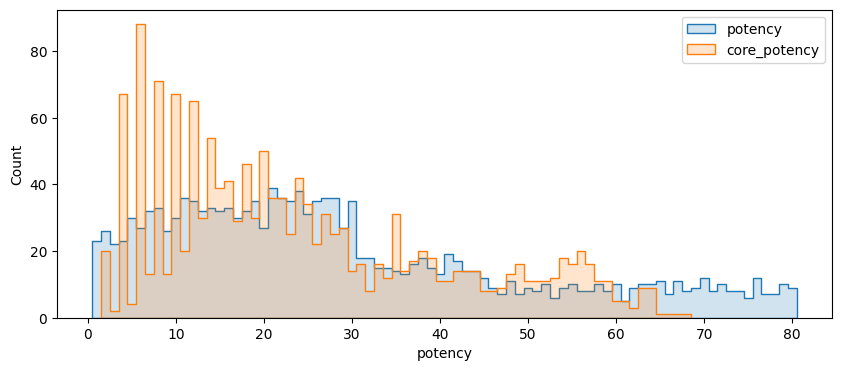

In [259]:
_ = sns.histplot(data=df, x="potency", discrete=True, element="step", alpha=0.2, label="potency")
_ = sns.histplot(data=df, x="core_potency", discrete=True, element="step", alpha=0.2, label="core_potency")
_ = plt.legend()



## Attributes vs potency

Note that it might seem counter-intuitive that costs go down with rising potency. But
keep in mind that potency is a measure of the overall value of a card/blueprint.

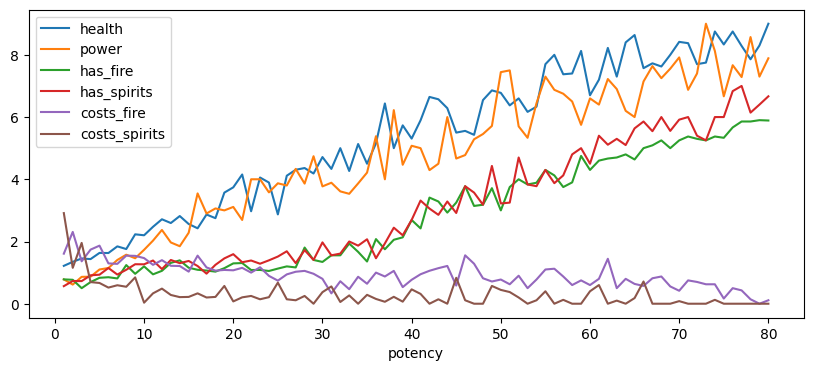

In [260]:
_ = sns.lineplot(data=df, x="potency", y="health", errorbar=None, label="health")
_ = sns.lineplot(data=df, x="potency", y="power", errorbar=None, label="power")
_ = sns.lineplot(data=df, x="potency", y="has_fire", errorbar=None, label="has_fire")
_ = sns.lineplot(data=df, x="potency", y="has_spirits", errorbar=None, label="has_spirits")
_ = sns.lineplot(data=df, x="potency", y="costs_fire", errorbar=None, label="costs_fire")
_ = sns.lineplot(data=df, x="potency", y="costs_spirits", errorbar=None, label="costs_spirits")
plt.gca().set_ylabel('')
_ = plt.legend()

## Power/health vs. potency

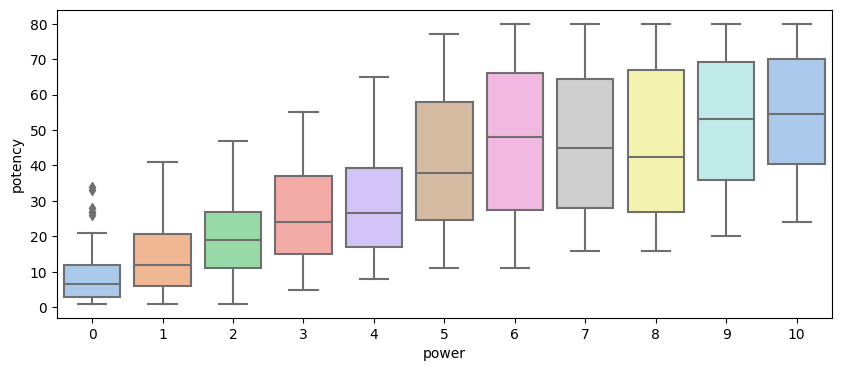

In [261]:
_ = sns.boxplot(data=df, x="power", y="potency", palette="pastel")

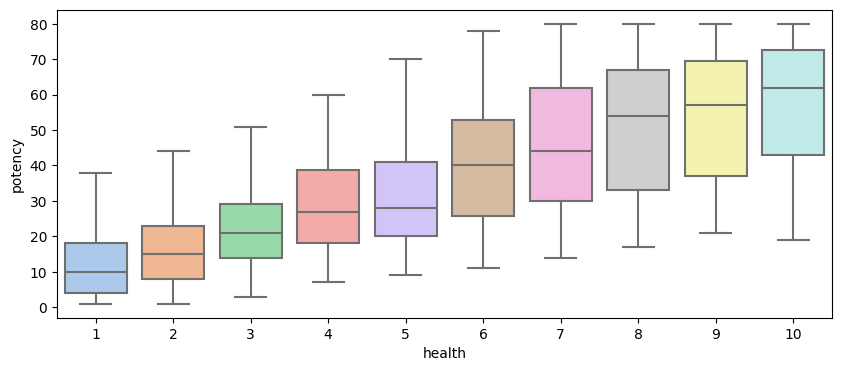

In [262]:
_ = sns.boxplot(data=df, x="health", y="potency", palette="pastel")

## Skills vs potencies

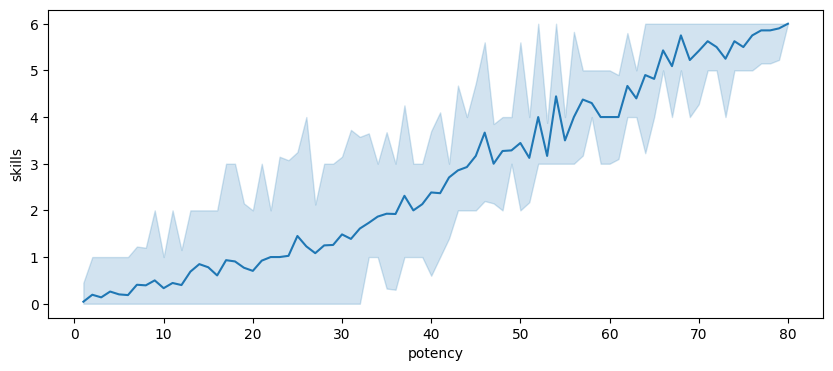

In [263]:
_ = sns.lineplot(data=df, x="potency", y="skills", errorbar=("pi", 95))

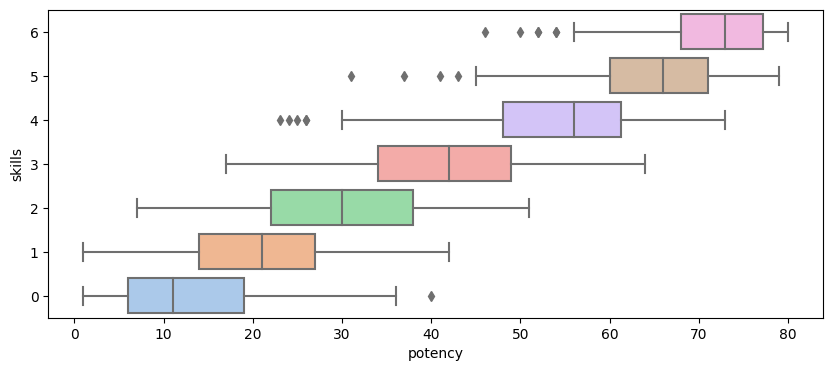

In [268]:
_ = sns.boxplot(data=df, x="potency", y="skills", palette="pastel", orient="h")
_ = plt.gca().invert_yaxis()

## Skill count histogram

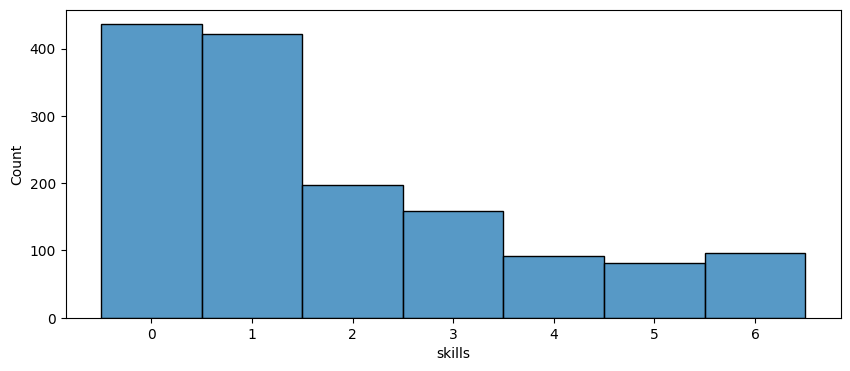

In [265]:
_ = sns.histplot(data=df, x="skills", discrete=True)

### Histograms of individual skills

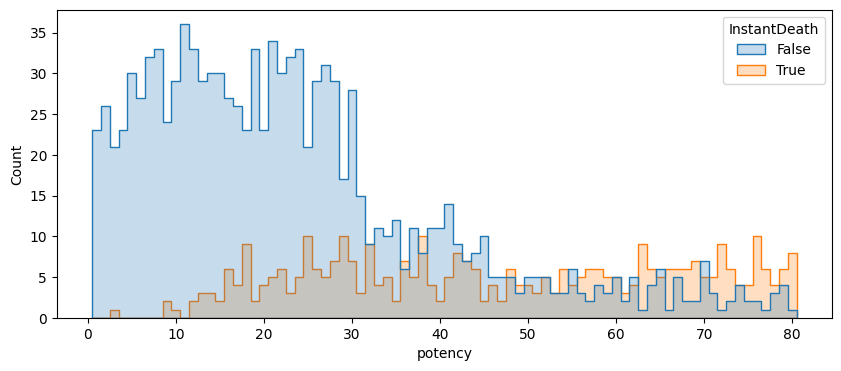

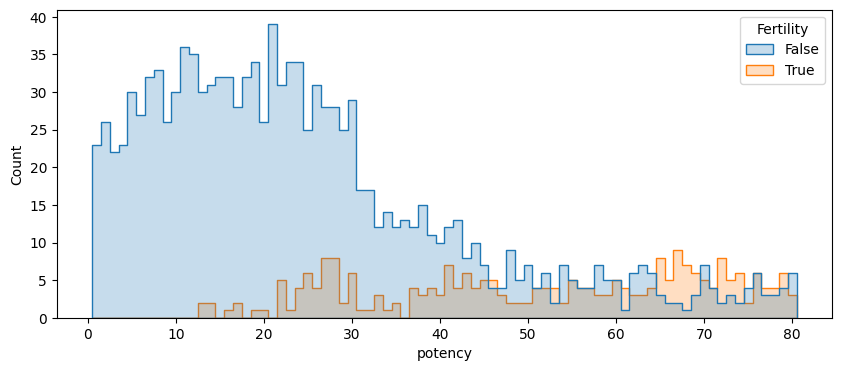

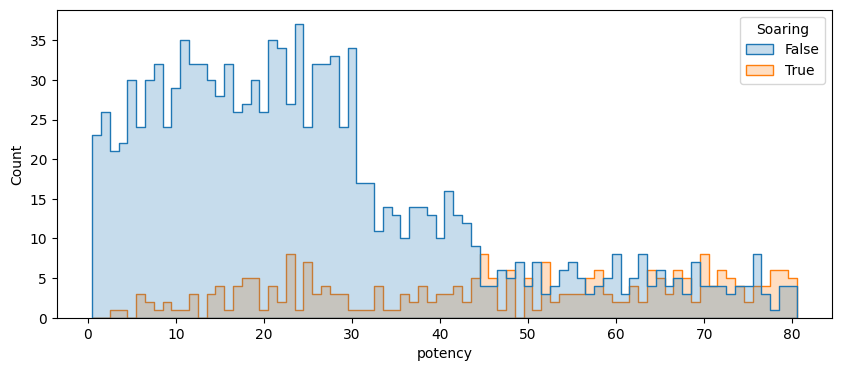

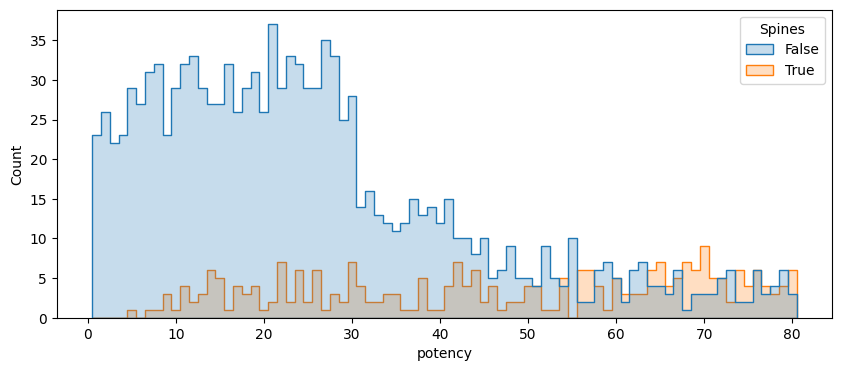

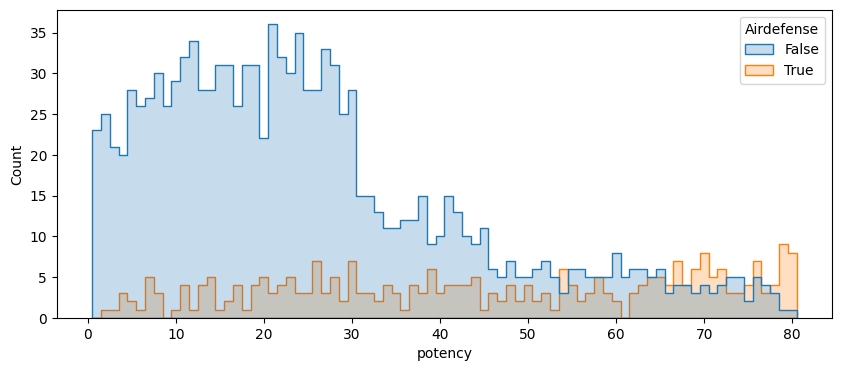

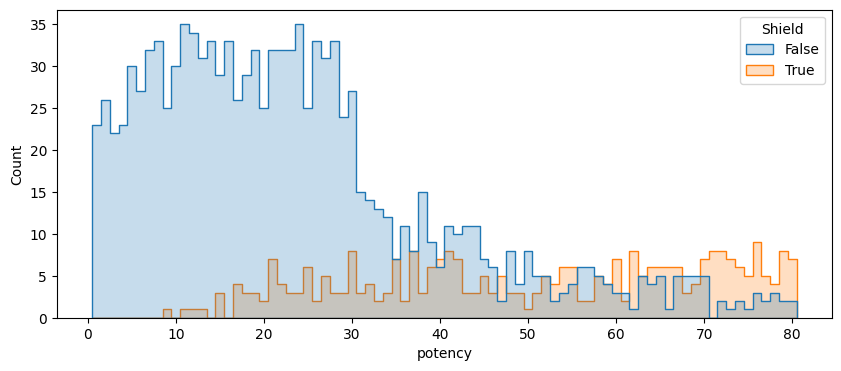

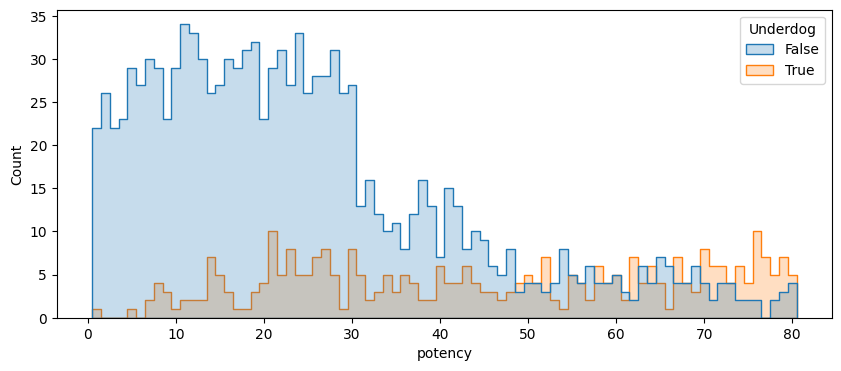

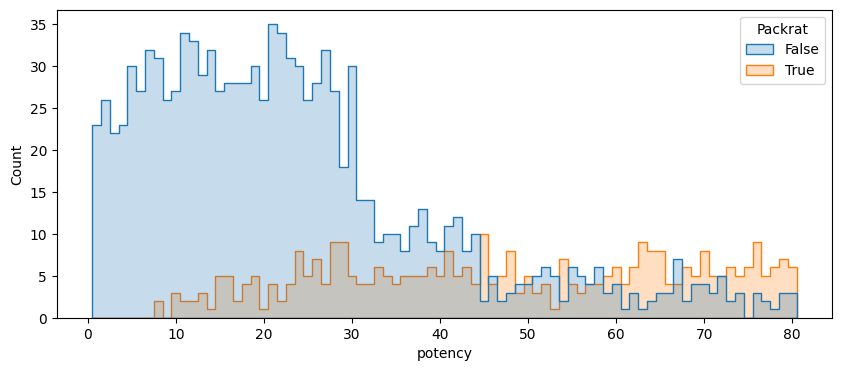

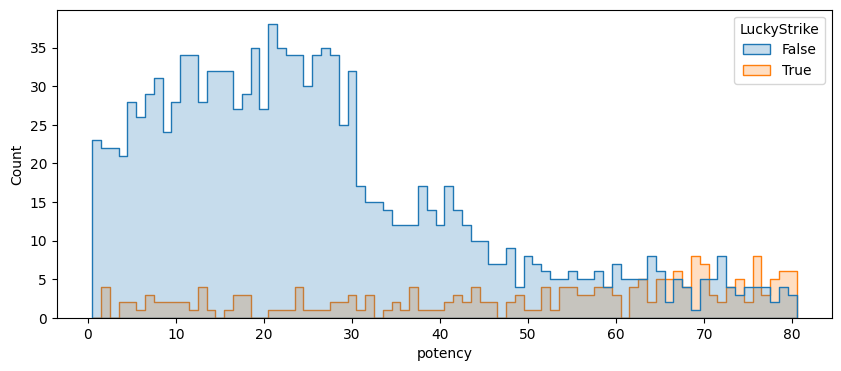

In [269]:
for s in  skill_names:
    sns.histplot(data=df, x="potency", discrete=True, hue=s, element="step")
    plt.show()
